# Part IV: Sentiment analysis using LSTM [20 points]
In this part, we perform a sentiment analysis using LSTM model. The final (improved) model should achieve a test accuracy of greater than 75%.

In [ ]:
!unzip -q aclImdb.zip -d /content/

In [ ]:
!pip install torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 938.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
!pip install torchtext==0.18.0

  Using cached torchtext-0.18.0-cp311-cp311-manylinux1_x86_64.whl.metadata (7.9 kB)
Using cached torchtext-0.18.0-cp311-cp311-manylinux1_x86_64.whl (2.0 MB)


In [ ]:
!pip install torchinfo

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove_embeddings

--2025-03-06 22:28:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-06 22:28:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-06 22:28:09--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

import nltk
import time
import spacy
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split


There was an error when trying to use torchnext as it was giving a version mismatch error with pytorch. Even after installing with the right version , there were still errors . So i am proceeding with using Spacy tokenizer

In [ ]:
!python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 106.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Step 1: Data exploration and preprocessing

1. Load your chosen dataset and print the main statistics

In [ ]:
#Function for loading the dataset , combining the postive reviews and negative reviews into one and shuffling so that the model doesnt learn any ordered patterns.
def CombineReviewsDataset(base_path):
  data = []
  splits = ["train", "test"]

  for split in splits:
    for sentiment in ["pos", "neg"]:
      sentiment_label = 1 if sentiment == "pos" else 0
      folder_path = os.path.join(base_path, split, sentiment)

      for filename in os.listdir(folder_path):
        with open(os.path.join(folder_path, filename), "r", encoding="utf-8") as file:
           data.append((file.read().strip(), sentiment_label))


    df = pd.DataFrame(data, columns=["review_text", "label"])

    # Shuffling the dataset to make sure there are no ordered patterns .
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    return df

base_path = "aclImdb"
df = CombineReviewsDataset(base_path)
print("Main Statistics for the dataset :")
print(df.info())


Main Statistics for the dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  25000 non-null  object
 1   label        25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


2. Print the first 5 rows of the dataset to understand its structure

In [ ]:
print("First 5 rows to understand the structure : ")
print(df.head())

First 5 rows to understand the structure : 
                                         review_text  label
0  Dana Andrews is one of those actors that I've ...      1
1  STAR RATING: ***** Saturday Night **** Friday ...      0
2  Walking with Cavemen, hosted by Alec Baldwin, ...      1
3  I gave this movie a rating of 1 (Awful). The o...      0
4  Spoilers will be in this. The movie could have...      0


3. Provide a brief description of the dataset

We used the Stanford movie reviews dataset . This dataset we used is for binary sentiment classification. The dataset provided has a set of 25,000 highly polar movie reviews for training, and 25,000 for testing.We have combined both ,shuffled and made it into one dataframe  .There is additional unlabeled data for use as well. Here is the link : https://ai.stanford.edu/~amaas/data/sentiment/

4. Display descriptive statistics

In [ ]:
print("\n Label Distribution:\n")
print(df['label'].value_counts())

print("\n Label Distribution Percentage:\n")
print(df['label'].value_counts(normalize=True) * 100)

print("\n Review Length - Number of Characters:\n")
print(df['review_text'].apply(len).describe())

print("\n Review Length Statistics - Number of Words:\n")
print(df['review_text'].apply(lambda x: len(x.split())).describe())


 Label Distribution:

label
1    12500
0    12500
Name: count, dtype: int64

 Label Distribution Percentage:

label
1    50.0
0    50.0
Name: proportion, dtype: float64

 Review Length - Number of Characters:

count    25000.000000
mean      1325.068600
std       1003.132835
min         52.000000
25%        702.000000
50%        979.000000
75%       1614.000000
max      13704.000000
Name: review_text, dtype: float64

 Review Length Statistics - Number of Words:

count    25000.000000
mean       233.787200
std        173.733032
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: review_text, dtype: float64


5. Handle missing values

In [ ]:
print("Missing Values Check:\n")
print(df.isnull().sum())

Missing Values Check:

review_text    0
label          0
dtype: int64


Answer :
There are no missing values in the dataset we chose from the given list in the assignment .If there were few missing values we can drop it mostly or keep placeholder texts.

6. Create visualizations to gain insights into the data

Text(0, 0.5, 'Frequency')

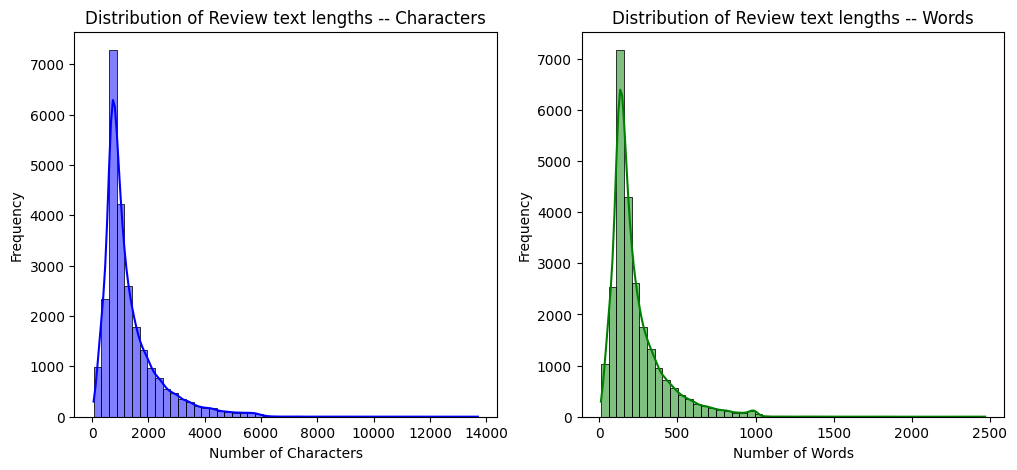

In [ ]:
df['char_length'] = df['review_text'].apply(len)
df['word_length'] = df['review_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['char_length'], bins=50, kde=True, color="blue")
plt.title("Distribution of Review text lengths -- Characters")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(df['word_length'], bins=50, kde=True, color="green")
plt.title("Distribution of Review text lengths -- Words")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")


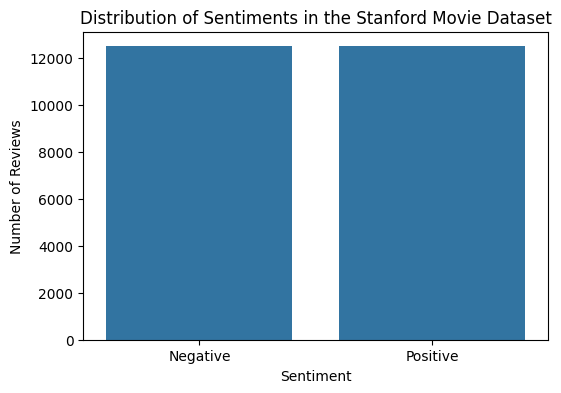

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'])
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"])
plt.title("Distribution of Sentiments in the Stanford Movie Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

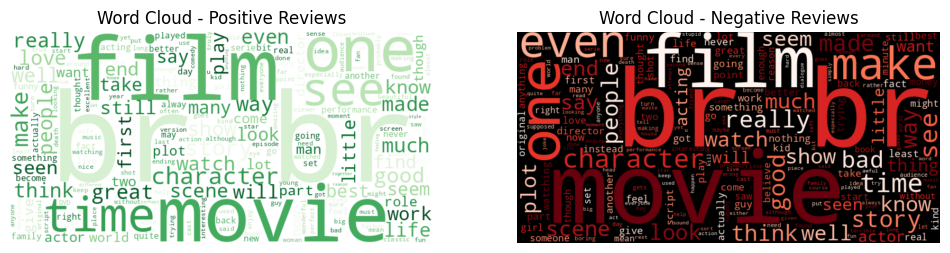

In [ ]:
positive_reviews = " ".join(df[df['label'] == 1]['review_text'])
negative_reviews = " ".join(df[df['label'] == 0]['review_text'])

wordcloudPos = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(positive_reviews)
wordcloudNeg = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(negative_reviews)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloudPos, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Reviews")

plt.subplot(1, 2, 2)
plt.imshow(wordcloudNeg, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Reviews")

plt.show()

Word cloud shows us that "br" which most likely a html tag is present in both the clouds(Positive and negative) .This can actually cause the model to perform badly . We will try to clean this before we go for data preparation .

In [ ]:
def clean_text(text):
    text = re.sub(r'<br\s*/?>', ' ', text)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text
df['cleaned_review'] = df['review_text'].apply(clean_text)

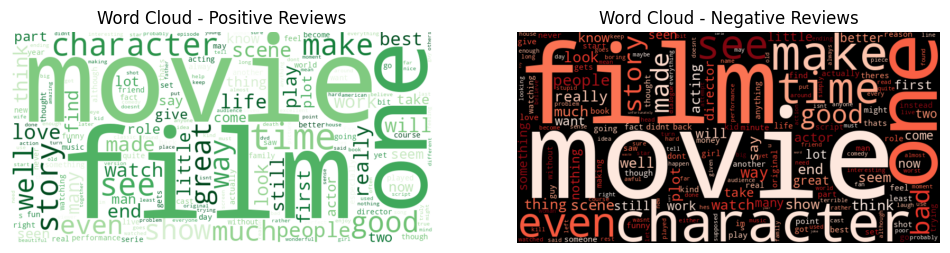

In [ ]:
positive_reviews = " ".join(df[df['label'] == 1]['cleaned_review'])
negative_reviews = " ".join(df[df['label'] == 0]['cleaned_review'])

wordcloudPos = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(positive_reviews)
wordcloudNeg = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(negative_reviews)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloudPos, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Reviews")

plt.subplot(1, 2, 2)
plt.imshow(wordcloudNeg, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Reviews")

plt.show()

7. Data preparation

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 20000, Validation size: 2500, Test size: 2500


In [ ]:
nltk.download('punkt_tab')
def tokenize_nltk(text):
    return word_tokenize(text)

def tokenize_spacy(text):
    doc = nlp(text)
    return [token.text for token in doc]

start_nltk = time.time()
df["nltk_tokens"] = df["cleaned_review"].apply(tokenize_nltk)
end_nltk = time.time()

start_spacy = time.time()
df["spacy_tokens"] = df["cleaned_review"].apply(tokenize_spacy)
end_spacy = time.time()

nltk_vocab = set(token for tokens in df["nltk_tokens"] for token in tokens)
spacy_vocab = set(token for tokens in df["spacy_tokens"] for token in tokens)

print(f"NLTK Tokenization Time: {end_nltk - start_nltk:.2f} sec, Vocabulary Size: {len(nltk_vocab)}")
print(f"SpaCy Tokenization Time: {end_spacy - start_spacy:.2f} sec, Vocabulary Size: {len(spacy_vocab)}")

print("\nSample NLTK Tokenized Review:", df["nltk_tokens"].iloc[0])
print("Sample SpaCy Tokenized Review:", df["spacy_tokens"].iloc[0])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


NLTK Tokenization Time: 16.04 sec, Vocabulary Size: 108657
SpaCy Tokenization Time: 814.40 sec, Vocabulary Size: 108626

Sample NLTK Tokenized Review: ['dana', 'andrews', 'is', 'one', 'of', 'those', 'actors', 'that', 'ive', 'probably', 'seen', 'in', 'a', 'dozen', 'films', 'but', 'who', 'has', 'never', 'really', 'registered', 'for', 'me', 'often', 'stolid', 'taciturn', 'playing', 'the', 'same', 'kinds', 'of', 'roles', 'and', 'looking', 'somewhat', 'like', 'the', 'similarly', 'underrated', 'glenn', 'ford', 'hes', 'an', 'actor', 'that', 'takes', 'some', 'effort', 'to', 'really', 'appreciate', 'but', 'once', 'you', 'hit', 'the', 'right', 'film', 'and', 'this', 'is', 'it', 'premingers', 'moody', 'look', 'at', 'new', 'yorks', 'underbelly', 'is', 'as', 'dirty', 'and', 'seedy', 'as', 'just', 'about', 'any', 's', 'noir', 'and', 'andrews', 'is', 'in', 'his', 'element', 'as', 'tootough', 'cop', 'mark', 'dixon', 'who', 'just', 'doesnt', 'know', 'how', 'to', 'play', 'the', 'game', 'to', 'get', 'ahe

In [ ]:
df.to_pickle("tokenized_reviews.pkl")


In [ ]:
df = pd.read_pickle("tokenized_reviews.pkl")

We experimented with Nltk and SpaCy for the tokenization of our words . After executing , we can clearly see that nltk is the best option . The justifications are given below .
Nltk processing time was 16.04 sec but SpaCy processing time was 814.40 sec . Vocabulary sizes are similar so that did not contribute to our preference. Nltk keeps the contractions together (I've is kept as ive) but SpaCy splits the contractions. Nltk handles numbers well when compared to SpaCy's , for eg for this sequence - "10/10" , this stays as one token , but spacy considers it as 3 tokens (10,/,10).

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 20000, Validation size: 2500, Test size: 2500


In [ ]:
word_counts = Counter(token for tokens in train_df["nltk_tokens"] for token in tokens)

vocab = {"<pad>": 0, "<unk>": 1}
for i, (word, _) in enumerate(word_counts.most_common(), start=2):
    vocab[word] = i

idx_to_word = {i: word for word, i in vocab.items()}

print(f"Vocabulary Size: {len(vocab)}")
print(f"Sample Word-to-Index Mapping: {dict(list(vocab.items())[:10])}")

Vocabulary Size: 96012
Sample Word-to-Index Mapping: {'<pad>': 0, '<unk>': 1, 'the': 2, 'and': 3, 'a': 4, 'of': 5, 'to': 6, 'is': 7, 'in': 8, 'it': 9}


In [ ]:
# Function to encode text into numerical sequences
def encode_text(text):
    return [vocab.get(token, vocab["<unk>"]) for token in text]

train_df["encoded"] = train_df["nltk_tokens"].apply(encode_text)
val_df["encoded"] = val_df["nltk_tokens"].apply(encode_text)
test_df["encoded"] = test_df["nltk_tokens"].apply(encode_text)

print("Sample Encoded Review:", train_df["encoded"].iloc[0])

Sample Encoded Review: [10356, 7, 4, 2912, 47549, 780, 4, 637, 742, 4, 932, 18, 21, 61, 4, 662, 372, 9, 7954, 14, 218, 33, 5406, 19, 14, 2, 1172, 12, 1146, 9, 15906, 13, 2633, 275, 15, 157, 2518, 5, 94, 386, 3, 667, 6, 6332, 16, 2, 91, 157, 3146, 5, 690, 2, 173, 297, 13802, 13, 33, 47550, 616, 115, 148, 4553, 1338, 27, 67, 41, 1011, 7261, 943, 4, 656, 94, 3, 67, 452, 2009, 301, 4, 87, 2171, 19012, 386, 2090, 3577, 3165, 3147, 3, 3234, 13803, 68, 31, 52, 265, 22071, 5, 66, 3944, 12691, 3044, 148, 68, 487, 39, 3, 237, 55, 96, 125, 1562, 4, 19, 14, 55, 1456, 129, 3165, 3147, 14, 39, 680, 13, 28, 5, 4, 2496, 40, 37, 941, 348, 36, 178, 615, 8, 94, 8, 2, 6550, 36, 111, 179, 3188, 2, 979, 104, 67, 3130, 15, 88, 27, 13, 4, 470, 5784, 289, 19013, 18, 8, 33, 4028, 736, 241, 71, 4028, 822, 95, 63, 90, 88, 308, 8, 1662, 551, 14, 2, 3604, 7657, 36, 7, 2, 64, 418, 185, 36, 59, 572, 12215, 118, 27, 7, 2549, 488, 4, 14465, 3, 2, 7378, 7, 4225, 3234, 13803, 7, 51, 6551, 71, 619, 11, 308, 289, 67, 2, 61

In [ ]:
max_length = int(train_df["encoded"].apply(len).quantile(0.95))  # 95th percentile
print(f"Max Sequence Length: {max_length}")

Max Sequence Length: 585


In [ ]:
# Function to pad/truncate
def pad_text(encoded_text, max_length):
    return encoded_text[:max_length] + [vocab["<pad>"]] * (max_length - len(encoded_text))

train_df["padded"] = train_df["encoded"].apply(lambda x: pad_text(x, max_length))
val_df["padded"] = val_df["encoded"].apply(lambda x: pad_text(x, max_length))
test_df["padded"] = test_df["encoded"].apply(lambda x: pad_text(x, max_length))

train_tensor = torch.tensor(train_df["padded"].tolist(), dtype=torch.long)
val_tensor = torch.tensor(val_df["padded"].tolist(), dtype=torch.long)
test_tensor = torch.tensor(test_df["padded"].tolist(), dtype=torch.long)

print("Sample Padded Sequence:", train_tensor[0])

Sample Padded Sequence: tensor([10356,     7,     4,  2912, 47549,   780,     4,   637,   742,     4,
          932,    18,    21,    61,     4,   662,   372,     9,  7954,    14,
          218,    33,  5406,    19,    14,     2,  1172,    12,  1146,     9,
        15906,    13,  2633,   275,    15,   157,  2518,     5,    94,   386,
            3,   667,     6,  6332,    16,     2,    91,   157,  3146,     5,
          690,     2,   173,   297, 13802,    13,    33, 47550,   616,   115,
          148,  4553,  1338,    27,    67,    41,  1011,  7261,   943,     4,
          656,    94,     3,    67,   452,  2009,   301,     4,    87,  2171,
        19012,   386,  2090,  3577,  3165,  3147,     3,  3234, 13803,    68,
           31,    52,   265, 22071,     5,    66,  3944, 12691,  3044,   148,
           68,   487,    39,     3,   237,    55,    96,   125,  1562,     4,
           19,    14,    55,  1456,   129,  3165,  3147,    14,    39,   680,
           13,    28,     5,     4,  249

8. Split dataset into train, validation, and test sets

The split is already done in the previous step , only after the split can we actually proceed to data preparation , because we got to only do it specifically to training set in certain processes.

## Step 2: Baseline LSTM Model

1. Build an LSTM model

In [ ]:
class LSTMForSentimentAnalysis(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout_prob):
        super(LSTMForSentimentAnalysis, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(
            input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=dropout_prob, bidirectional=False
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.to(torch.long)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)

        final_output = torch.mean(lstm_out, dim=1)

        return self.fc(final_output)

# Model Parameters
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 128
num_layers = 3
output_dim = 1
dropout_prob = 0.2

Basemodel = LSTMForSentimentAnalysis(vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout_prob)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Basemodel = Basemodel.to(device)
train_tensor = train_tensor.to(device)
val_tensor = val_tensor.to(device)
test_tensor = test_tensor.to(device)

print(summary(Basemodel, input_size=(32, max_length), dtypes=[torch.long]))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMForSentimentAnalysis                 [32, 1]                   --
├─Embedding: 1-1                         [32, 585, 128]            12,289,536
├─LSTM: 1-2                              [32, 585, 128]            396,288
├─Linear: 1-3                            [32, 1]                   129
Total params: 12,685,953
Trainable params: 12,685,953
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 7.81
Input size (MB): 0.15
Forward/backward pass size (MB): 38.34
Params size (MB): 50.74
Estimated Total Size (MB): 89.23


2. Train your model

In [ ]:
train_labels = torch.tensor(train_df["label"].values, dtype=torch.float32).to(device)
val_labels = torch.tensor(val_df["label"].values, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_df["label"].values, dtype=torch.float32).to(device)

#Datasets
train_dataset = TensorDataset(train_tensor, train_labels)
val_dataset = TensorDataset(val_tensor, val_labels)
test_dataset = TensorDataset(test_tensor, test_labels)

#DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for batch in train_loader:
    print(f"Batch Shape: {batch[0].shape}, Labels Shape: {batch[1].shape}")
    break

Batch Shape: torch.Size([32, 585]), Labels Shape: torch.Size([32])


In [ ]:
criterion = nn.BCEWithLogitsLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(Basemodel.parameters(), lr=learning_rate)

Basemodel = Basemodel.to(device)

In [ ]:
num_epochs = 10
train_losses_baseModel, val_losses_baseModel = [], []
train_accuracies_baseModel, val_accuracies_baseModel = [], []

# Training Loop
for epoch in range(num_epochs):
    Basemodel.train()
    total_train_loss, total_train_correct, total_train_samples = 0, 0, 0

    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = Basemodel(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        preds = (torch.sigmoid(outputs) > 0.5).float()
        total_train_correct += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses_baseModel.append(avg_train_loss)

    train_accuracy = total_train_correct / total_train_samples * 100
    train_accuracies_baseModel.append(train_accuracy)

    Basemodel.eval()
    total_val_loss, total_val_correct, total_val_samples = 0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = Basemodel(inputs).squeeze()
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            total_val_correct += (preds == labels).sum().item()
            total_val_samples += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses_baseModel.append(avg_val_loss)

    val_accuracy = total_val_correct / total_val_samples * 100
    val_accuracies_baseModel.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

Epoch 1/10 - Train Loss: 0.6764, Train Acc: 56.44% - Val Loss: 0.6310, Val Acc: 65.24%
Epoch 2/10 - Train Loss: 0.6362, Train Acc: 64.92% - Val Loss: 0.6282, Val Acc: 65.84%
Epoch 3/10 - Train Loss: 0.6507, Train Acc: 62.30% - Val Loss: 0.6537, Val Acc: 63.60%
Epoch 4/10 - Train Loss: 0.6162, Train Acc: 66.70% - Val Loss: 0.6132, Val Acc: 66.68%
Epoch 5/10 - Train Loss: 0.5803, Train Acc: 70.58% - Val Loss: 0.5919, Val Acc: 68.08%
Epoch 6/10 - Train Loss: 0.5563, Train Acc: 72.79% - Val Loss: 0.6543, Val Acc: 67.20%
Epoch 7/10 - Train Loss: 0.5248, Train Acc: 75.31% - Val Loss: 0.5363, Val Acc: 75.32%
Epoch 8/10 - Train Loss: 0.4544, Train Acc: 79.94% - Val Loss: 0.4851, Val Acc: 78.56%
Epoch 9/10 - Train Loss: 0.4150, Train Acc: 82.12% - Val Loss: 0.4713, Val Acc: 78.80%
Epoch 10/10 - Train Loss: 0.3894, Train Acc: 83.10% - Val Loss: 0.4653, Val Acc: 78.00%


We have trained a model for a total of 10 epochs with the model having three lstm layers ,
embedding dimensions of 128,
hidden dimensions of 128,
output dimensions of 1,
dropout probability of 0.4

3. Evaluation and analysis

In [ ]:
Basemodel.eval()

total_test_loss = 0
total_test_correct = 0
total_test_samples = 0

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = Basemodel(inputs).squeeze()
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()

        preds = (torch.sigmoid(outputs) > 0.5).float()
        total_test_correct += (preds == labels).sum().item()
        total_test_samples += labels.size(0)

# Average Test Loss & Accuracy
avg_test_loss = total_test_loss / len(test_loader)
test_accuracy = total_test_correct / total_test_samples * 100

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.4729, Test Accuracy: 78.16%


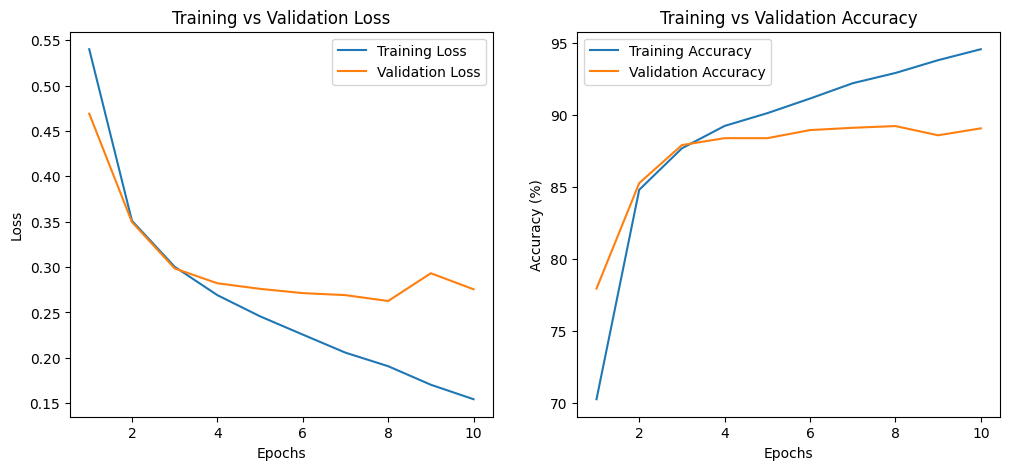

In [ ]:
# Plot Training & Validation Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses_baseModel, label="Training Loss")
plt.plot(range(1, num_epochs+1), val_losses_baseModel, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accuracies_baseModel, label="Training Accuracy")
plt.plot(range(1, num_epochs+1), val_accuracies_baseModel, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.show()

Precision: 0.7328
Recall: 0.8864
F1-score: 0.8023


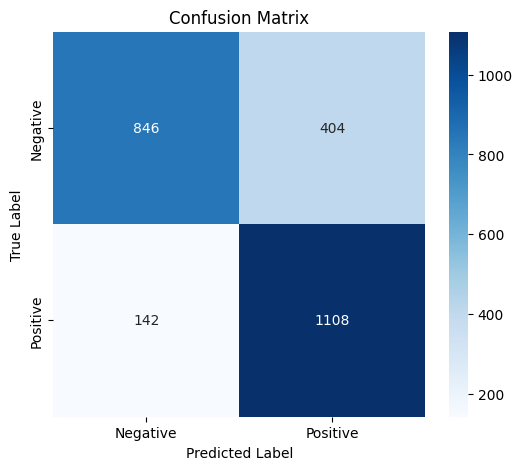

In [ ]:
Basemodel.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = Basemodel(inputs).squeeze()
        preds = (torch.sigmoid(outputs) > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

conf_matrix = confusion_matrix(all_labels, all_preds)

precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

4. Save the weights of the trained neural network

In [ ]:
torch.save(Basemodel.state_dict(), "base_model_weights.pth")

## Step 3: Improved LSTM Model

1. Improve your baseline LSTM model

In [ ]:
glove_path = "glove_embeddings/glove.6B.100d.txt"

def load_glove_embeddings(glove_path):
    glove_dict = {}
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            glove_dict[word] = vector
    return glove_dict

glove_dict = load_glove_embeddings(glove_path)


In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((len(vocab), embedding_dim))

for word, idx in vocab.items():
    if word in glove_dict:
        embedding_matrix[idx] = glove_dict[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
print(f"shape : {embedding_matrix.shape}")

shape : torch.Size([96012, 100])


2. Create a new class for your improved model

In [ ]:
class ImprovedLSTMForSentimentAnalysis(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob):
        super(ImprovedLSTMForSentimentAnalysis, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=0)

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob,
            bidirectional=True
        )
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
      x = x.to(torch.long)
      embedded = self.embedding(x)

      gru_out, _ = self.gru(embedded)

      attn_weights = F.softmax(self.attention(gru_out), dim=1)
      attn_output = torch.sum(gru_out * attn_weights, dim=1)
      return self.fc(attn_output)



# Model Parameters
embedding_dim = 100
hidden_dim = 128
num_layers = 3
dropout_prob = 0.2

model = ImprovedLSTMForSentimentAnalysis(vocab_size, embedding_dim, hidden_dim, num_layers,dropout_prob)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_tensor = train_tensor.to(device)
val_tensor = val_tensor.to(device)
test_tensor = test_tensor.to(device)
print(summary(model, input_size=(32, max_length), dtypes=[torch.long]))

Layer (type:depth-idx)                   Output Shape              Param #
ImprovedLSTMForSentimentAnalysis         [32, 1]                   --
├─Embedding: 1-1                         [32, 585, 100]            9,601,200
├─GRU: 1-2                               [32, 585, 256]            769,536
├─Linear: 1-3                            [32, 585, 1]              257
├─Linear: 1-4                            [32, 1]                   257
Total params: 10,371,250
Trainable params: 10,371,250
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 14.71
Input size (MB): 0.15
Forward/backward pass size (MB): 53.46
Params size (MB): 41.48
Estimated Total Size (MB): 95.10


3. Follow the same training and evaluation procedures

In [ ]:
criterion = nn.BCEWithLogitsLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate ,  weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

model = model.to(device)

In [ ]:
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss, total_train_correct, total_train_samples = 0, 0, 0

    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        total_train_correct += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = total_train_correct / total_train_samples * 100
    train_accuracies.append(train_accuracy)

    scheduler.step()

    model.eval()
    total_val_loss, total_val_correct, total_val_samples = 0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            total_val_correct += (preds == labels).sum().item()
            total_val_samples += labels.size(0)
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = total_val_correct / total_val_samples * 100
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

Epoch 1/10 - Train Loss: 0.5401, Train Acc: 70.23% - Val Loss: 0.4691, Val Acc: 77.92%
Epoch 2/10 - Train Loss: 0.3510, Train Acc: 84.78% - Val Loss: 0.3496, Val Acc: 85.24%
Epoch 3/10 - Train Loss: 0.3004, Train Acc: 87.66% - Val Loss: 0.2985, Val Acc: 87.88%
Epoch 4/10 - Train Loss: 0.2691, Train Acc: 89.21% - Val Loss: 0.2821, Val Acc: 88.36%
Epoch 5/10 - Train Loss: 0.2457, Train Acc: 90.09% - Val Loss: 0.2760, Val Acc: 88.36%
Epoch 6/10 - Train Loss: 0.2256, Train Acc: 91.11% - Val Loss: 0.2713, Val Acc: 88.92%
Epoch 7/10 - Train Loss: 0.2057, Train Acc: 92.17% - Val Loss: 0.2691, Val Acc: 89.08%
Epoch 8/10 - Train Loss: 0.1907, Train Acc: 92.88% - Val Loss: 0.2626, Val Acc: 89.20%
Epoch 9/10 - Train Loss: 0.1703, Train Acc: 93.77% - Val Loss: 0.2932, Val Acc: 88.56%
Epoch 10/10 - Train Loss: 0.1543, Train Acc: 94.53% - Val Loss: 0.2755, Val Acc: 89.04%


In [ ]:
model.eval()

total_test_loss = 0
total_test_correct = 0
total_test_samples = 0

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()

        preds = (torch.sigmoid(outputs) > 0.5).float()
        total_test_correct += (preds == labels).sum().item()
        total_test_samples += labels.size(0)

# Compute Average Test Loss & Accuracy
avg_test_loss = total_test_loss / len(test_loader)
test_accuracy = total_test_correct / total_test_samples * 100

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.2706, Test Accuracy: 89.40%


4. Directly compare the performance of your improved model to the baseline model


Base LSTM Model Performance:
Test Loss: 0.4729, Test Accuracy: 78.16%
Precision: 0.7328, Recall: 0.8864, F1-score: 0.8023

Improved LSTM Model Performance:
Test Loss: 0.2706, Test Accuracy: 89.40%
Precision: 0.8815, Recall: 0.9104, F1-score: 0.8957


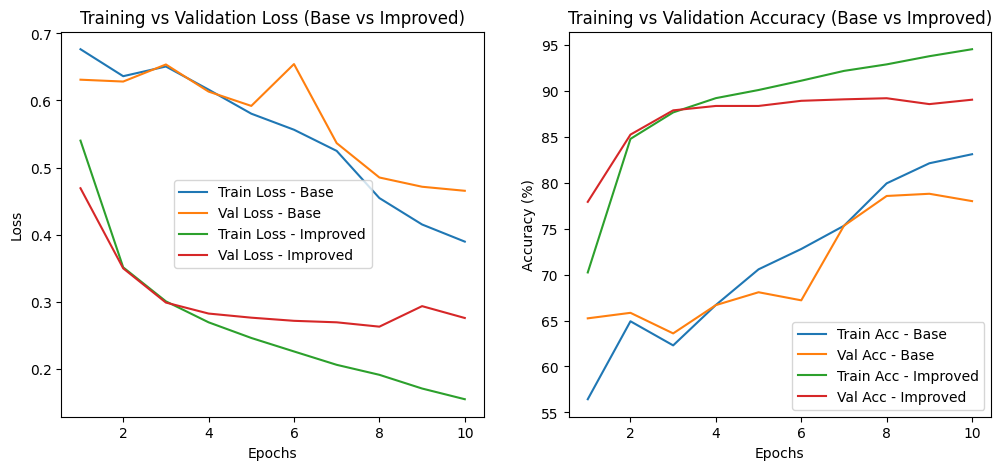

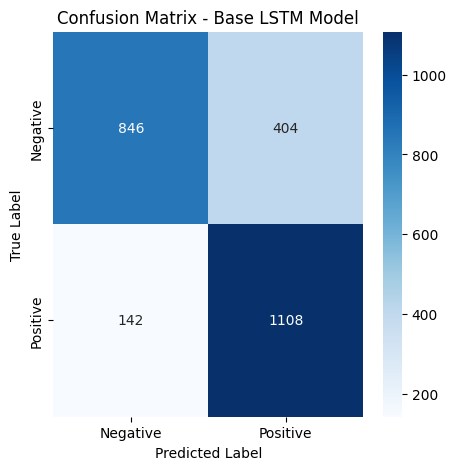

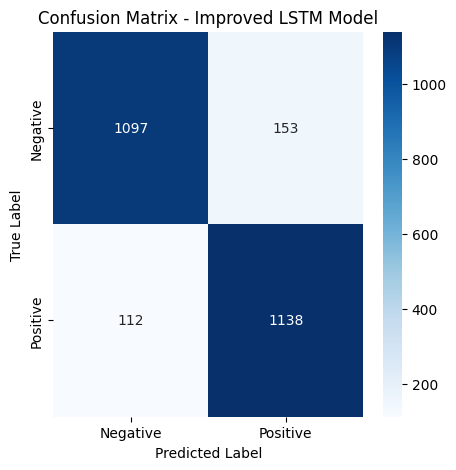

In [ ]:
def evaluate_model(model, test_loader, model_name):
    model.eval()
    total_test_loss, total_test_correct, total_test_samples = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            total_test_correct += (preds == labels).sum().item()
            total_test_samples += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = total_test_correct / total_test_samples * 100

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary", zero_division=1)

    print(f"\n{model_name} Performance:")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    return all_preds, all_labels, test_accuracy


#Base Model
base_preds, base_labels, base_test_acc = evaluate_model(Basemodel, test_loader, "Base LSTM Model")

# Improved Model
improved_preds, improved_labels, improved_test_acc = evaluate_model(model, test_loader, "Improved LSTM Model")


# Training and Validation Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses_baseModel, label="Train Loss - Base")
plt.plot(range(1, num_epochs+1), val_losses_baseModel, label="Val Loss - Base")
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss - Improved")
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss - Improved")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss (Base vs Improved)")

#Training and Validation Accuracy
plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accuracies_baseModel, label="Train Acc - Base")
plt.plot(range(1, num_epochs+1), val_accuracies_baseModel, label="Val Acc - Base")
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Acc - Improved")
plt.plot(range(1, num_epochs+1), val_accuracies, label="Val Acc - Improved")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training vs Validation Accuracy (Base vs Improved)")

plt.show()


# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

plot_confusion_matrix(base_labels, base_preds, "Base LSTM Model")
print("\n")
plot_confusion_matrix(improved_labels, improved_preds, "Improved LSTM Model")

<span style='color:green'>### YOUR ANSWER ###</span>

5. Save the weights of the trained neural network

In [ ]:
torch.save(model.state_dict(), "Improved_model_weights.pth")

## Step 4: Discussion

1. Briefly describe the dataset and its key characteristics

Answer : We used the Stanford movie reviews dataset . This dataset we used is for binary sentiment classification. The dataset provided has a set of 25,000 highly polar movie reviews for training, and 25,000 for testing.We have combined both ,shuffled and made it into one dataframe .There is additional unlabeled data for use as well. Here is the link : https://ai.stanford.edu/~amaas/data/sentiment/ .

The data set contains 25,000 reviews uniformly distributed across the two classes (50% label 0 and 50% label 1). There is one review in the form of text per each review, and the review lengths are highly varied. A review is about 1,325 characters on average with lengths varying between a minimum of 52 characters and a maximum of 13,704, and the median length is 979 characters. In terms of length of words, the reviews vary on average to approximately 234 words, covering between 10 to 2,470 words and a midpoint of 174 words. The diversity, indicated by the standard deviations (approximately 1,003 characters and 174 words), suggests that the data comprises an assorted list of short and long reviews.

There are no missing values in the dataset we chose from the given list in the assignment .If there were few missing values we can drop it mostly or keep placeholder texts.

2. Describe both your baseline and improved LSTM architectures in detail

The base LSTM model begins with an embedding layer that converts input tokens to 128 dimensional vectors, creating a dense representation of the text. The embeddings are then passed through a three layer LSTM with 128 hidden units per layer. The LSTM, with a dropout probability of 0.2 between layers, learns to capture temporal dependencies in the text. Instead of relying on the final hidden state, the model computes the average of the outputs along the entire sequence and produces a fixed length representation, which is further fed through a linear layer for sentiment score prediction. While successful, this design contains a huge number of parameters,a total of approximately 12.69 million parameters.

This Improved LSTM model is using a GRU based architecture with an inbuilt attention mechanism. It begins with an embedding layer that converts input tokens into 100 dimensional vectors with the help of pre trained embeddings which are also fine tuned during training. The embeddings are fed into a three layer bidirectional GRU that consumes contextual information from previous and subsequent tokens, providing a 256 dimensional output at each time step. An attention layer subsequently weights each time step, so the model is focusing on the most important parts of the sequence; these are then used to compute a weighted sum of the GRU outputs. A fully connected layer subsequently maps this aggregate representation to the output space.T he model is trainable with over 10 million parameters.

3. Discuss the results, comparing the performance of the baseline and improved models

Ans : Comparison of base and improved LSTM models indicated some significant performance improvements. Base model indicated a steady decline in training loss but showedvslow decline in validation loss, indicating little overfitting. Compared to it, the improved model indicated declining training as well as validation loss steadily, which indicates better generalization and stable learning process.

In measuring accuracy, the base model had a test accuracy of 75.92%, while the improved model substantially outperformed it with a test accuracy of 89.40%. The validation accuracy of the improved model was steadier across epochs, while the base model experienced variability, which means that the improved model was stronger and less susceptible to overfitting.

In the confusion matrices, the base model misclassified 404 negative reviews as positive and 142 positive reviews as negative, which led to worse overall accuracy. The improved model significantly reduced these misclassifications to only 153 false positives and 112 false negatives, meaning that it was more capable of separating sentiment classes(better accuracy).

Comparison of precision, recall, and F1-score reinforces the stength of the improved model. Whereas the base model recorded a precision of 0.7328, recall of 0.8864, and F1-score of 0.8023, the improved model recorded a precision of 0.8815, recall of 0.9104, and F1-score of 0.8957. These improvements indicate that not only is the better model more accurate, but it is also better able to balance precision and recall, thus being a more reliable classifier.

4. Discuss the strengths and limitations of using recurrent neural models for sentiment analysis

Recurrent neural models, such as LSTM, do have several strengths when applied to sentiment analysis. One of their primary strengths is they are well suited for capturing sequential dependencies in text. As opposed to CNN, which treat words in isolation, recurrent models maintain contextual knowledge through long sentences, enabling more nuanced judgments of sentiment. This is particularly useful for handling complex sentence structures,context-dependent sentiment reversals.

Another benefit of recurrent neural models is their capacity to be trained from large-volume text data without relying on engineered features. LSTMs and GRUs will often learn semantic representations from raw text itself, while traditional machine learning models require huge feature engineering.The combination of pre-trained word embeddings such as GloVe or Word2Vec enhances the strength for semantic relations and gives generalized performance over a range of text inputs.

Recurrent neural models also have limitations. A significant limitation is that they are computationally inefficient. It takes a lot of processing power to train LSTMs and GRUs, particularly for lengthy sequences, since they take in words one at a time instead of in parallel. This translates to increased training time and more compute power. Additionally, recurrent models suffer from very long sequences due to the vanishing gradient issue, thus they are not able to retain information from the start of the text. Even though attention mechanisms mitigate this issue, they still do not eliminate it entirely.

One limitation is that they are prone to overfitting, especially when trained on small datasets. Since recurrent models have numerous parameters, they require large datasets to train in order to generalize. Without sufficient data or regularization technique, they will memorize instances of the training set rather than fitting to patterns that can be generalized, and will not generalize well to new data.

5. References. Include details on all the resources used to complete this part.

Hochreiter, S., & Schmidhuber, J. (1997). “Long Short-Term Memory.” Neural Computation, 9(8), 1735–1780.

youtube : https://youtu.be/YCzL96nL7j0?si=WXvCjY1GWu3h9Td4    --> StatmanQuest

Pytorch - https://pytorch.org/docs/stable/index.html

gru's and lstm - https://youtu.be/8HyCNIVRbSU?si=LVsH24xS26Guw1mN  -- youtube